# Getting the contents of GitHub Repo

With these commands you can get the contents of the respective [GitHub repo](https://github.com/ait-energy/iesopt-trainings/tree/main). The relevant folder is the `twinvector-summerschool-2025/`

In [ ]:
import os
from pathlib import Path
notebook_dir = os.getcwd()

%cd $notebook_dir

if not os.path.exists("iesopt-trainings"):
    !git clone https://github.com/ait-energy/iesopt-trainings.git
else:
    print("Repo already exists, skipping clone.")
print("Working directory of this notebook: ", notebook_dir)
%cd $notebook_dir
%cd iesopt-trainings/twinvector-summerschool-2025/
print("FIles in twinvector repo: ", notebook_dir)

!ls

# Adding files to this notebook


Use drag & drop (only for files, not full folders)

You can drag files directly into the Colab file explorer (left sidebar). For folders, zip them first.

 After unzipping, your folder will be inside `/content/`, usually with the same name as the zip file (without the .zip) unless the archive contains its own folder structure.

 You can unzip it by copy-pasting the command below into a code line, after you dragged the `dir.zip` into the left directory-side

 ```python
 !unzip opt.zip
 ```

# Install dependencies

We install iesoptools and iesopt.

In [ ]:
!pip install iesopt -q
!pip install git+https://github.com/sstroemer/iesopt-tools.git@d2447eadc8afc7c4cf4e7750dcecb36dc40d21a6 -q


From here on, the notebook is the same as in case of the [jupyter notebook in the GitHub Repo](https://github.com/ait-energy/iesopt-trainings/blob/main/twinvector-summerschool-2025/summerschool_example_iesopt.ipynb)



# Running the model

After setting up everything in the YAMLs (in the `opt/` folder), we call ` iesopt.run(...)`, that runs the optimization problem.
The forst argument is the main YAML - config file. The argument `parameters` allows us to modify the parameters that we have defined in the YAMLs previously.

For example `price_electricity_buy = "dayahead_price@data", price_electricity_sell = 10.0`

would model buying at the day-ahead price and selling (feed-in) at a fixed price of 10.0 EUR/MWh.

**Note:** the import may take some time!

In [9]:
from iesopttools import RDB, Figure, Trace
import iesopt

In [10]:
model = iesopt.run(
    "opt/config_summerschool2025.iesopt.yaml",
    parameters=dict(
        # price_electricity_buy = "dayahead_price@data", price_electricity_sell = 10.0
    ),
)

## Convert and extract the results

After we have the solution of the problem (i.e. set-point powers of the single components at the given timesteps) we extract and save the for the subsequent post-processing in csv format into the `opt/out` folder.

On extracting the results from the solved IESopt model, you can also consult the [documentation](https://ait-energy.github.io/iesopt/notebooks/custom_results_1.html#accessing-model-results-objectives).

In [11]:
def extract_results_to_csv(model, output_subdir =""):
    df_results = model.results.to_pandas()

    # list components
    print( "## MODEL COMPONENTs: ##\n", df_results["component"].unique() )
    output_dir = Path("opt/out") / output_subdir
    output_dir.mkdir(parents=True, exist_ok=True)
    # electricity buy / sell
    base = Path.cwd()   # defaults to current notebook cwd
    output_dir = base / "opt" / "out" / output_subdir
    output_dir.mkdir(parents=True, exist_ok=True)
    elec_buy = df_results.query("component == 'buy_electricity' and field == 'value'")
    elec_sold = df_results.query("component == 'sell_electricity' and field == 'value'")
    combo = elec_buy.merge(elec_sold, how="inner", on="snapshot", suffixes=("_buy", "_sell"))
    combo.to_csv(os.path.join(output_dir, "elec_buy_sell.csv"))

    # pv
    pv = df_results.query("component == 'pv' and field == 'value'")
    # load
    load = df_results.query("component == 'load' and field == 'value'")
    combo=pv.merge(load, how="inner", on="snapshot", suffixes=("_pv", "_load"))
    combo.to_csv(os.path.join(output_dir, "pv_load.csv"))

    # battery
    batt_charge = df_results.query(
        "component.str.endswith('.charging') and fieldtype == 'exp' and field =='in_electricity'",
        engine="python"
    )
    batt_discharge = df_results.query(
        "component.str.endswith('.discharging') and fieldtype == 'exp' and field =='in_electricity'",
        engine="python"
    )
    combo =batt_charge.merge(batt_discharge, how="inner", on="snapshot", suffixes=("_charge", "_discharge"))
    combo.to_csv(os.path.join(output_dir, "batt_charge_discharge.csv"))
extract_results_to_csv(model)


## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']


# Vizualization

The library `iesopttools` allows us to vizualize the results we obtained,

In [12]:

def visualize(model):
    rdb = RDB()
    entry = rdb.add_entry(model)

    fig = Figure(style="seaborn", barmode="relative", labels=dict(title="electricity: supply / demand", x="time", y="MW"))

    for asset in entry.query("carrier", "node = 'grid_electricity' AND direction = 'out'"):
        fig.add(Trace("bar", entry.select(asset)))

    for asset in entry.query("carrier", "node = 'grid_electricity' AND direction = 'in'"):
        fig.add(Trace("bar", entry.select(asset), sign=-1.0))


    return fig

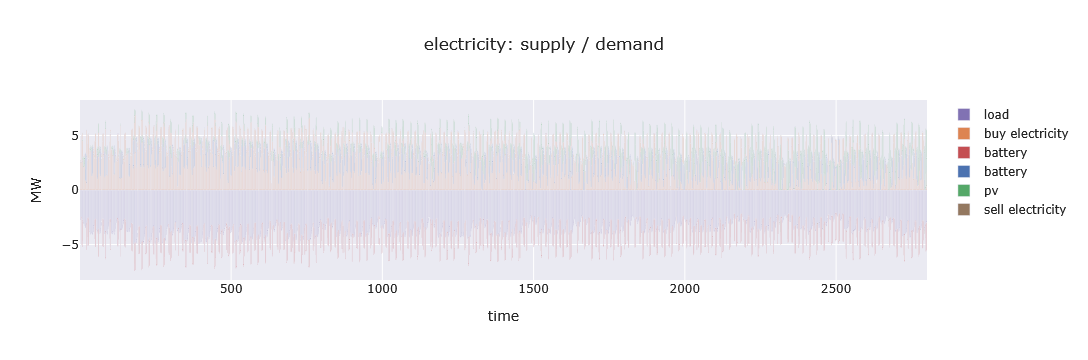

In [13]:
fig = visualize(model)
fig.render(xslice=(0,2800))
fig.show()
fig._fig.write_html("opt/out/plot_summerschool.html")


# Looping over configurations

#### The basic setup
```csv
name,type,carrier,p,e
load,Demand,electricity,5.0 * demand@data,
pv,RES,,5.0 * generation_solar@data,
```

```yaml
parameters:
  price_electricity_buy: 1e4
  price_electricity_sell: 1e4
  p_bess: 2.5
  h_bess: 10.0

  # etc ....
  battery:
    type: BESS
    p: <p_bess>
    e: <h_bess> *<p_bess>
```

This means we have in the basic a
- 5MW PV.
- 2.5 MW - 4h BESS

In [14]:
battery_powers = [2.5, 5.0, 7.5]
battery_hours = [2.0, 4.0]

for p in battery_powers:
    for h in battery_hours:
        model = iesopt.run(
            "opt/config_summerschool2025.iesopt.yaml",
            parameters=dict(
                p_bess = p, h_bess = h,
            ),
        )
        extract_results_to_csv(model, f"p_{p}_h_{h}")
        fig = visualize(model)
        fig.render(xslice=(0,2800))
        fig._fig.write_html(f"opt/out/p_{p}_h_{h}/plot_summerschool.html")

## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']
## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']
## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']
## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']
## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']
## MODEL COMPONENTs: ##
 ['battery.discharging' 'battery.storage' 'pv' 'battery' 'buy_electricity'
 'load' 'sell_electricity' 'battery.charging' 'grid_electricity']


In [4]:
import pandas as pd

### Read optimization outputs
!!! path has to be adjusted to actual results !!!

In [ ]:
df_res = pd.read_csv()